# Bibliotecas

Nesta seção vamos instalar todas as bibliotecas utilizadas.

Além do OpenStreetMap, foram utilizadas: geopandas, pandas e networkx, mas estas já estão disponíveis no jupyter.

In [157]:
!pip install osmnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.4/328.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.5 MB/s eta 0:00:00


# Preparação

Nesta seção, vamos preparar o grafo com os dados recolhidos [neste repositório](https://github.com/lemuel-manske/city-block/tree/main/data) e organizar vértices e arestas por bairro.

1. Gerar o grafo composto de Blumenau, Timbó e Indaial (integrantes Lemuel e Lucas são de Blumenau e Rodrigo de Timbó)

In [186]:
BLUMENAU = 'Blumenau, Brazil'
TIMBO = 'Timbó, Brazil'
INDAIAL = 'Indaial, Brazil'

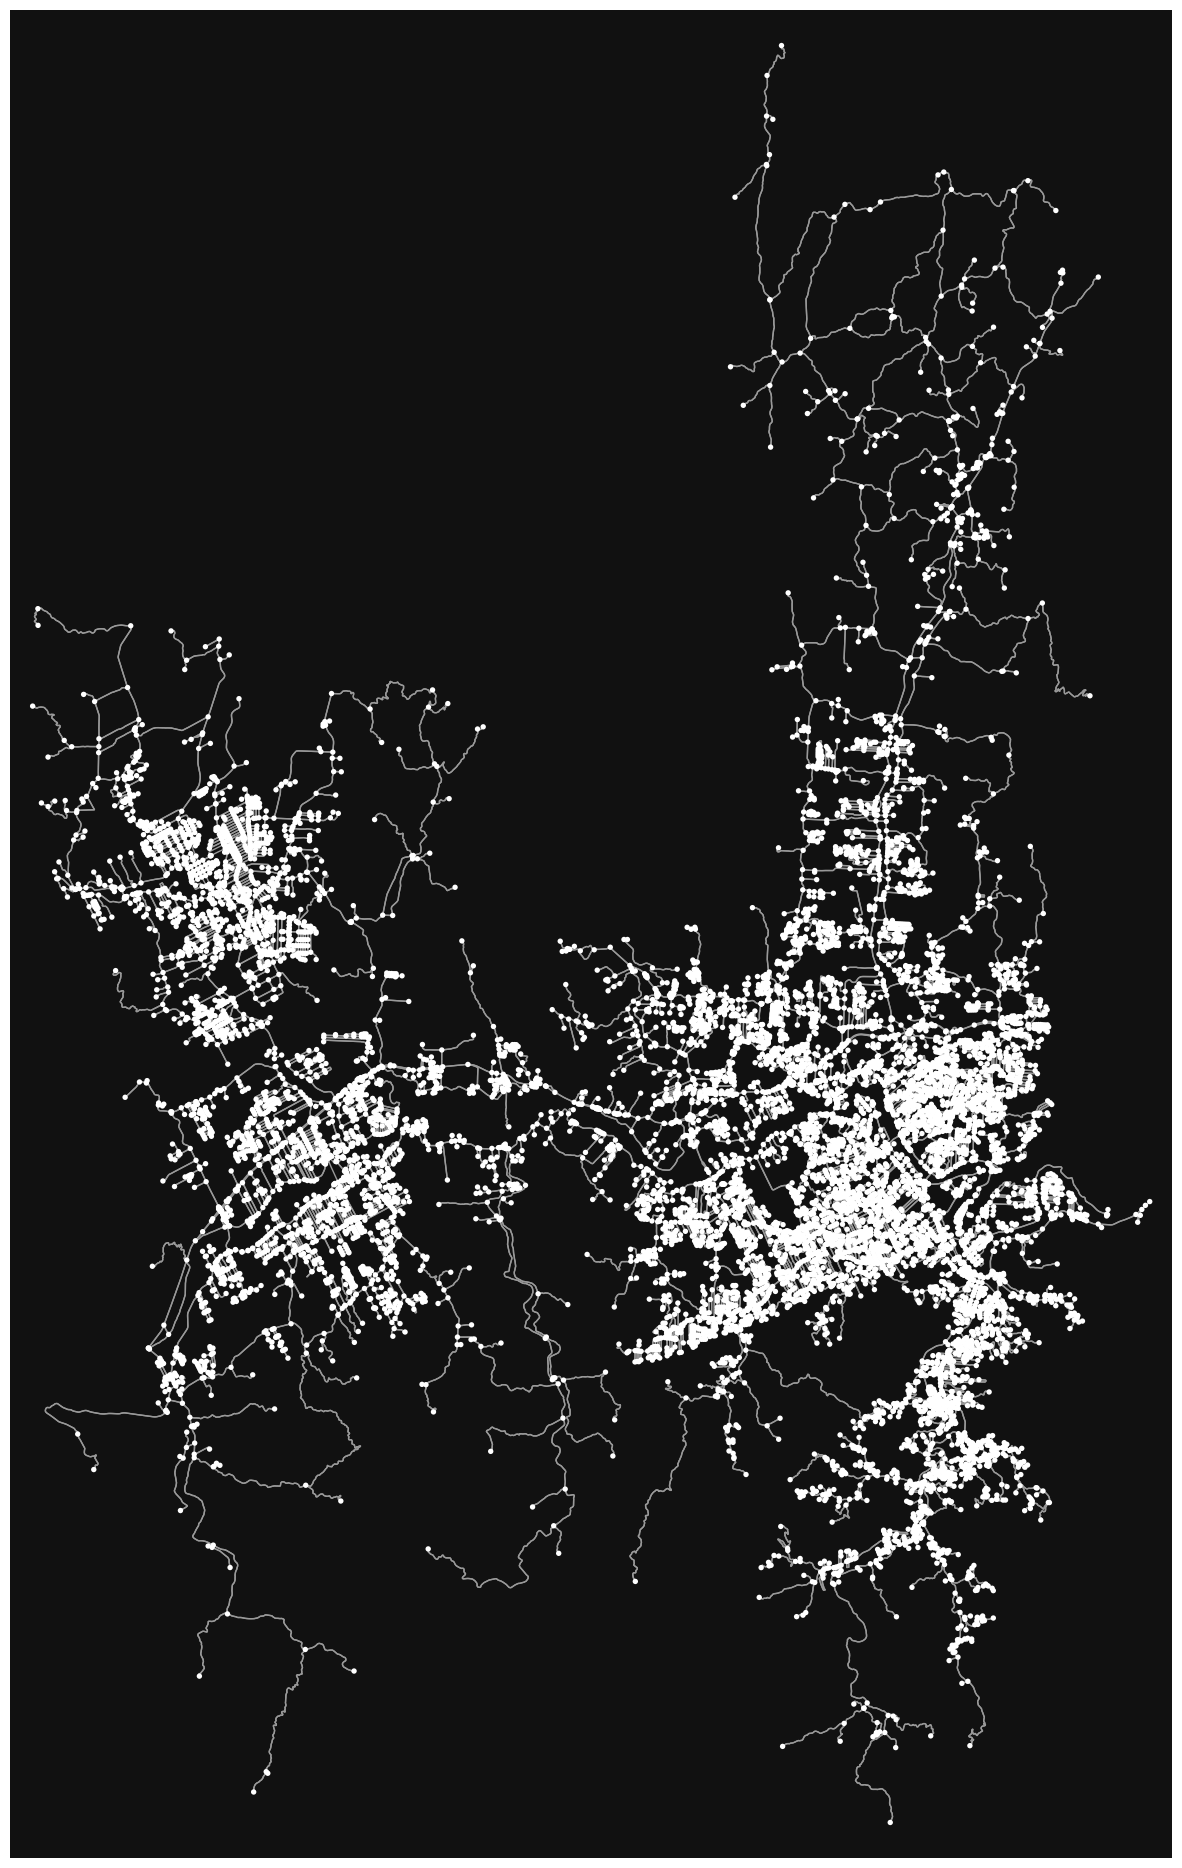

(<Figure size 2400x2400 with 1 Axes>, <Axes: >)

In [187]:
import osmnx as ox
import networkx as nx

G_blumenau = ox.graph_from_place(
    BLUMENAU,
    network_type='drive'
)

G_timbo = ox.graph_from_place(
    TIMBO,
    network_type='drive'
)

G_indaial = ox.graph_from_place(
    INDAIAL,
    network_type='drive'
)

G = nx.compose_all([G_blumenau, G_timbo, G_indaial])

ox.plot_graph(G, figsize=(24, 24))

2. Importar os dados recolhidos para o grafo. Para este processo, foram coletadas longitude - `x` - e latitude - `y` - de cada ponto de interesse e no grafo vamos atribuir um "label" e "nome" para o vértice mais próximo ao ponto de interesse desejado. Todos os datasets estão disponíveis [neste repositório](http://github.com/lemuel-manske/city-block/data)
  - https://osmnx.readthedocs.io/en/stable/user-reference.html#osmnx.distance.nearest_nodes

In [149]:
import pandas as pd
import networkx as nx

'''
  Labels with `label` the nodes of interest from a `dataframe` in a graph `G`.

  Tags are the information that the node needs to store for
  post processing, e.g. `student_name`.
'''
def label_points_of_interest(G: nx.MultiDiGraph, dataframe: pd.DataFrame, label: str, tags: list[str]):
  for idx, row in dataframe.iterrows():
    x = row['x']
    y = row['y']

    nearest_node_from_interest_point = ox.distance.nearest_nodes(G, X=x, Y=y)

    G.nodes[nearest_node_from_interest_point]['label'] = label

    for tag in tags:
      G.nodes[nearest_node_from_interest_point][tag] = row[tag]

DATA_FRAMES = {
    'hospital': 'https://raw.githubusercontent.com/lemuel-manske/city-block/main/data/hospitals.csv',
    'student': 'https://raw.githubusercontent.com/lemuel-manske/city-block/main/data/students.csv',
    'childcare': 'https://raw.githubusercontent.com/lemuel-manske/city-block/main/data/childcare.csv',
}

def load_dataset(dataset_name, tags):
  df = pd.read_csv(DATA_FRAMES[dataset_name])
  label_points_of_interest(G, df, dataset_name, tags)

load_dataset('hospital', ['name', 'is_public'])
load_dataset('student', ['name', 'student_name'])
load_dataset('childcare', ['name'])

3. Afim de facilitar a análise, vamos separar todas os vértices e arestas por bairro. Foi necessário remover os bairros que não são reconhecidos na divisão administrativa feita pela prefeitura [neste link](https://www.blumenau.sc.gov.br/secretarias/secretaria-de-desenvolvimento-urbano/pagina/historia-sobre-municipio/divisa-administrativa-bairros) mas que o OSM reconhece.

  - https://osmnx.readthedocs.io/en/stable/user-reference.html#osmnx.features.features_from_place
  - https://wiki.openstreetmap.org/wiki/Key:admin_level

In [151]:
import pandas as pd

DESIRED_BLUMENAU_NEIGHBORHOODS = pd \
  .read_csv('https://raw.githubusercontent.com/lemuel-manske/city-block/main/data/blumenau_neighborhoods.csv') \
  ['name']

DESIRED_TIMBO_NEIGHBORHOODS = pd \
  .read_csv('https://raw.githubusercontent.com/lemuel-manske/city-block/main/data/timbo_neighborhoods.csv') \
   ['name']

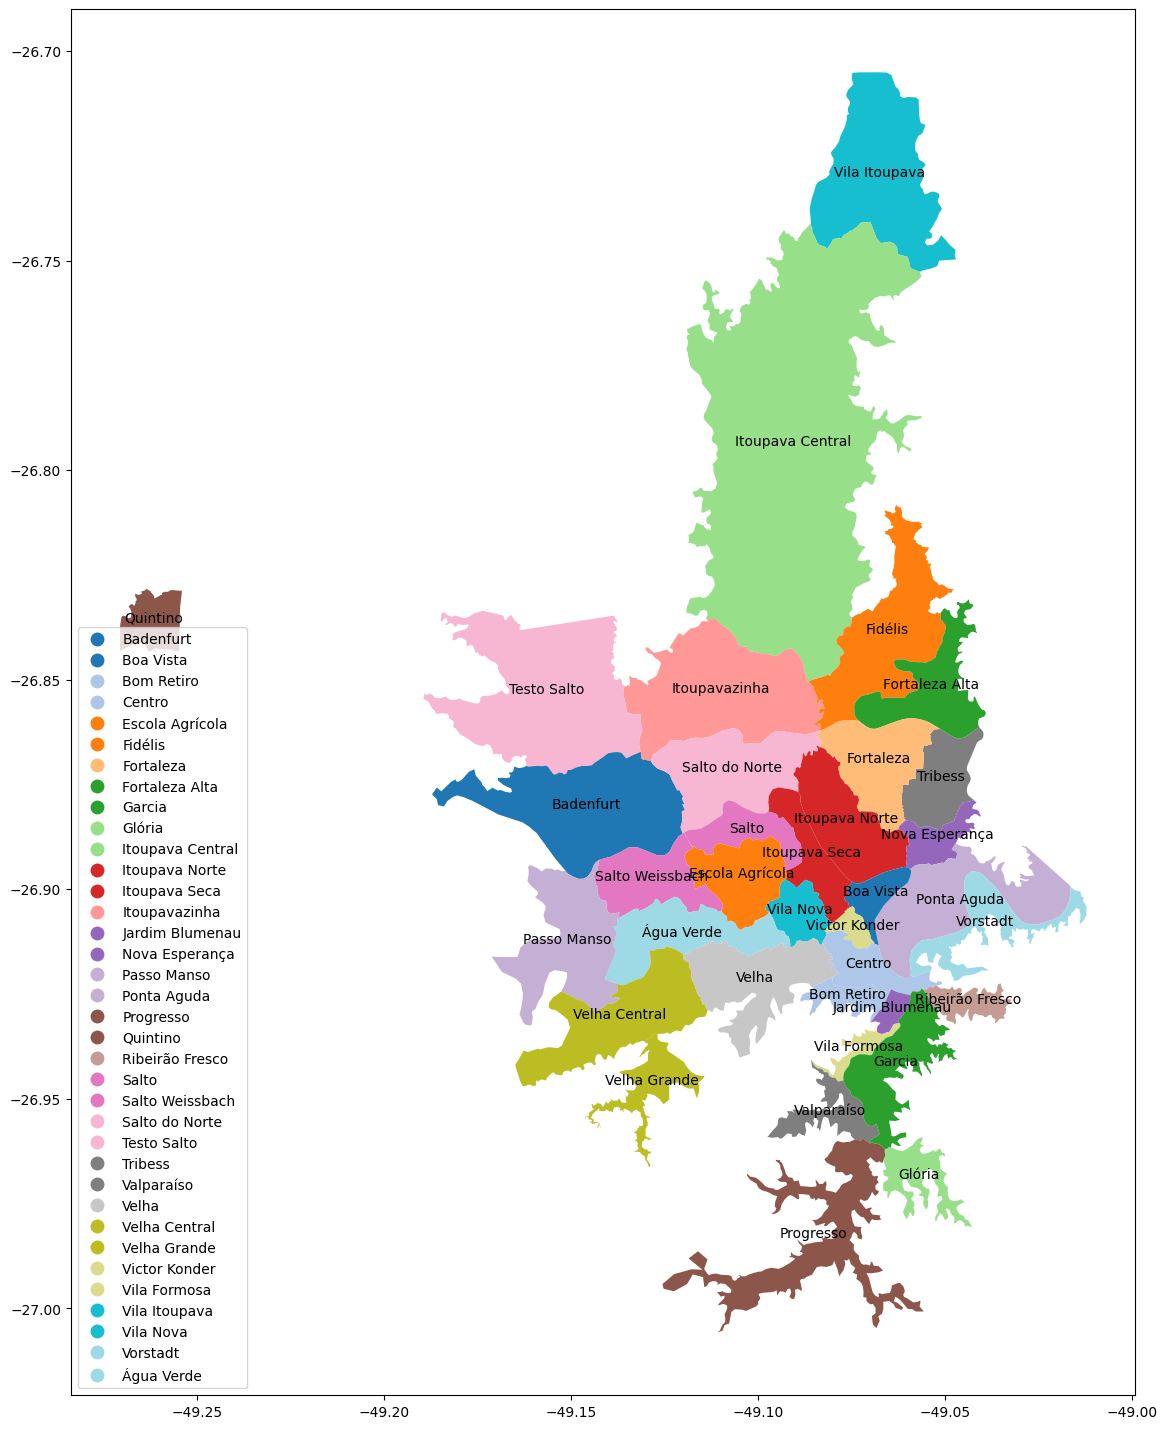

In [189]:
import pandas as pd

import osmnx as ox

import matplotlib.pyplot as plt

blumenau_neighborhoods = ox.features \
  .features_from_place(BLUMENAU, { 'admin_level': '10' })

blumenau_neighborhoods = blumenau_neighborhoods[
    blumenau_neighborhoods['name'].isin(DESIRED_BLUMENAU_NEIGHBORHOODS)
]

timbo_neighborhoods = ox.features \
  .features_from_place(TIMBO, { 'admin_level': '10' })

timbo_neighborhoods = timbo_neighborhoods[
    timbo_neighborhoods['name'].isin(DESIRED_TIMBO_NEIGHBORHOODS)
]

neighborhoods = pd.concat([blumenau_neighborhoods, timbo_neighborhoods])

neighborhoods.plot(column='name', cmap='tab20', legend=True, figsize=(16, 18))

neighborhoods.apply(lambda p: plt.annotate(text=p['name'], xy=p.geometry.centroid.coords[0], ha='center'), axis=1);

4. Com o geopandas, podemos fazer um [*spatial join*](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.sjoin.html#geopandas.GeoDataFrame.sjoin) dos vértices - `G_nodes` - do grafo original que sobrepoem - `predicate='intersects'` - qualquer polígono - `neighborhoods[['geometry']]`. Por fim, renomeamos a coluna de `name_right` para `name` para manter consistência. A saída são todos os vértices de `G`, porém agora estão identificados por bairro.

 - https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.html


In [144]:
import geopandas as gpd

import osmnx as ox

G_nodes, G_edges = ox.graph_to_gdfs(G) # MultiDiGraph to GeoDataFrame

nodes_with_neighborhood = gpd \
  .sjoin(G_nodes, neighborhoods[['name', 'geometry']], how='left', predicate='intersects') \
  .rename(columns={'name_right': 'name'})

5. Vamos modificar o grafo original `G` atribuindo a cada vértice seu respectivo bairro:

In [145]:
neighborhoods_dict = nodes_with_neighborhood['name'].to_dict()

nx.set_node_attributes(G, neighborhoods_dict, 'neighborhood_name')

6. E filtrando vértices do bairro "Centro", temos um subgrafo que representa o Centro de Blumenau.

  1. Para melhorar a exibição, utilizando pyplot podemos exibir o conjunto: polígono + grafo, resultando em:

<Axes: >

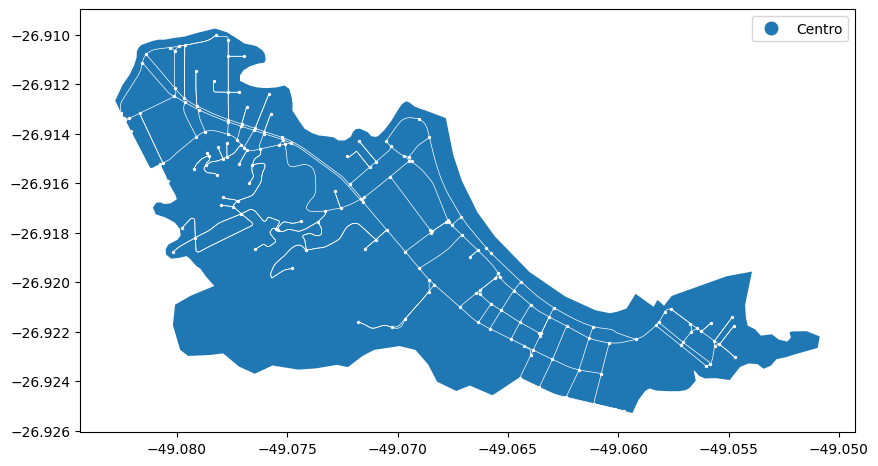

In [146]:
import matplotlib.pyplot as plt

list_to_filter = ['Centro']

fig, ax = plt.subplots(figsize=(10, 10))

G_sub_downtown = G \
  .subgraph(nodes_with_neighborhood[nodes_with_neighborhood['name'].isin(list_to_filter)].index) \
  .copy()

# plotting polygon - first layer
GDF_downtown = neighborhoods[neighborhoods['name'].isin(list_to_filter)]

GDF_downtown.plot(ax=ax, column='name', cmap='tab20', legend=True)

# plotting graph (nodes & edges) - second layer
G_downtown_nodes, G_downtown_edges = ox.graph_to_gdfs(G_sub_downtown)

G_downtown_edges.plot(ax=ax, linewidth=0.5, color='w')
G_downtown_nodes.plot(ax=ax, markersize=2, color='w')

# Análise

Nesta seção vamos gerar informações a partir dos dados coletados anteriormente.

In [196]:
import networkx as nx

'''
  Returns the shortest path from student by it's `student_name` to the closest
  `target_service`.
'''
def closest_service(student_name: str, target_service: str) -> list[int]:
  start = G_nodes[
    (G_nodes['label'] == 'student') &
    (G_nodes['student_name'] == student_name)
  ].index[0]

  hospital_nodes = G_nodes[
    (G_nodes['label'] == target_service)
  ]

  curr_shortest_path = None

  for _, hospital in hospital_nodes.iterrows():
    end = hospital.name

    new_path = nx.dijkstra_path(G, start, end, weight='length')

    curr_path_dist = nx.dijkstra_path_length(G, start, end)
    new_path_dist = nx.dijkstra_path_length(G, start, end)

    if curr_shortest_path is None or new_path_dist < curr_path_dist:
      curr_shortest_path = new_path

  return curr_shortest_path

closest_service('lucas', 'hospital')

[np.int64(3517771297),
 663141738,
 663141741,
 672581505,
 1075414862,
 3380564934,
 748363024,
 679639282,
 664643867,
 666595816,
 672581506,
 663141753,
 688298980,
 679639285,
 664643861,
 663137039,
 1095620458,
 3564678667,
 1120459079,
 663137037,
 665034659,
 4060939691,
 665034665,
 8916452226,
 2299664528,
 1844049561,
 5397308273,
 8612403369,
 1844049560,
 1215864477,
 656516487]

In [162]:
import folium as fl
import geopandas as gpd
import networkx as nx

from ipywidgets import interact

def line_off_neighborhoods(m):
  fields = ['name']

  fl.GeoJson(
    neighborhoods.to_json(),
    name='Bairros',

    tooltip=fl.GeoJsonTooltip(labels=False, fields=fields, max_width=100)
  ).add_to(m)

def mark_out_students(m, nodes):
  fields = ['student_name', 'name', 'neighborhood_name']

  marker = fl.Marker(
    icon=fl.Icon(color='blue', icon='home')
  )

  popup_html = '''
    <label><input type="checkbox"> Closest Hospital</label><br>
    <label><input type="checkbox"> Closest Childcare</label><br>
  '''

  popup = fl.Popup(
    fl.Html(popup_html, script=True),
    max_width=300
  )

  fl.GeoJson(
    nodes,
    name='Estudantes',
    popup=popup,
    marker=marker,
    tooltip=fl.GeoJsonTooltip(fields=fields, max_width=100)
  ).add_to(m)

def mark_out_hospitals(m, nodes):
  fields = ['name', 'neighborhood_name']

  marker = fl.Marker(
    icon=fl.Icon(color='red', icon='h-square', prefix='fa')
  )

  fl.GeoJson(
    nodes,
    name='Hospitais',
    marker=marker,
    tooltip=fl.GeoJsonTooltip(fields=fields, max_width=100)
  ).add_to(m)

def mark_out_childcare(m, nodes):
  fields = ['name', 'neighborhood_name']

  marker = fl.Marker(
    icon=fl.Icon(color='green', icon='child', prefix='fa')
  )

  fl.GeoJson(
    nodes,
    name='Creches',
    marker=marker,
    tooltip=fl.GeoJsonTooltip(fields=fields, max_width=100)
  ).add_to(m)

G_nodes, _ = ox.graph_to_gdfs(G)

center = G_nodes.geometry.union_all().centroid

m = fl.Map(location=[center.y, center.x], zoom_start=14)

line_off_neighborhoods(m)

mark_out_students(m, G_nodes[G_nodes['label'] == 'student'])
mark_out_hospitals(m, G_nodes[G_nodes['label'] == 'hospital'])
mark_out_childcare(m, G_nodes[G_nodes['label'] == 'childcare'])

fl.LayerControl().add_to(m)

m